# Exploring the Python AST Ecosystem

- H. Chase Stevens
- Senior Data Science Engineer at <img style='display:inline; margin: 0' src='teikametrics-logo-75.png'>
- @hchasestevens on twitter
- http://github.com/hchasestevens/europython-2018

In [10]:
import ast
import astor
import showast

## What you should get out of this talk:
- ASTs aren't scary!
- AST-based tooling for:
  - static analysis
  - code manipulation
- Practical examples
- Resources for writing your own AST tooling

## What I want to get out of this talk:

<center><img src='prometheus.png' /></center>

# What is an AST?

In [11]:
x = 1 + 2

In [12]:
import ast
parsed = ast.parse("x = 1 + 2")
parsed

In [13]:
ast.dump(parsed)

"Module(body=[Assign(targets=[Name(id='x', ctx=Store())], value=BinOp(left=Num(n=1), op=Add(), right=Num(n=2)))])"

In [14]:
import astor
astor.dump_tree(parsed.body[0])

"Assign(targets=[Name(id='x')], value=BinOp(left=Num(n=1), op=Add, right=Num(n=2)))"

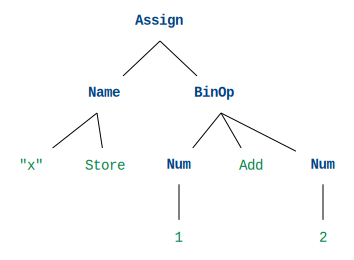

In [15]:
%%showast
x = 1 + 2

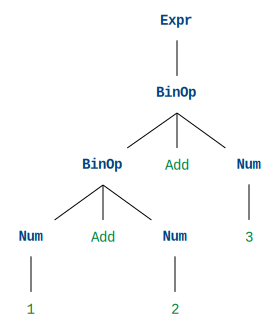

In [16]:
%%showast
1 + 2 + 3

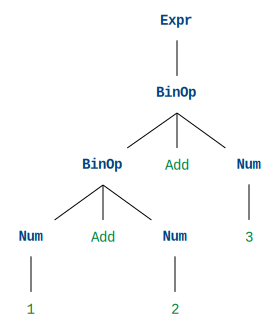

In [17]:
%%showast
(1 + 2) + 3

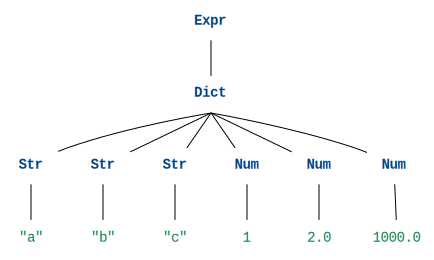

In [18]:
%%showast
{'a': 1, 'b': 2.0, 'c': 1e3}

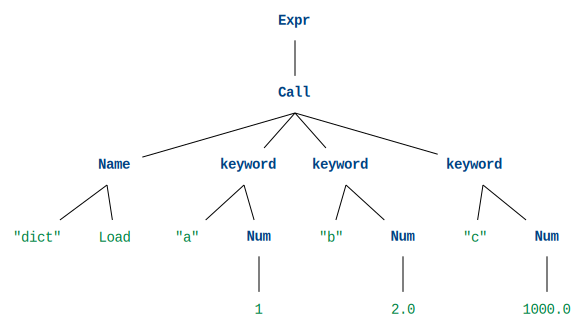

In [19]:
%%showast
dict(a=1, b=2.0, c=1e3)

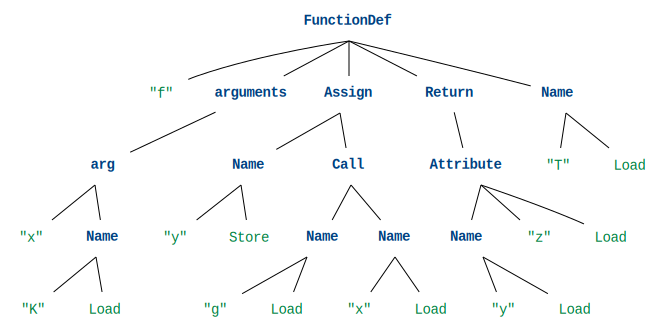

In [20]:
%%showast
def f(x: K) -> T:
    y = g(x)
    return y.z

In [21]:
print(astor.dump_tree(ast.parse("""
def f(x: K) -> T:
    y = g(x)
    return y.z
""").body[0]))

FunctionDef(name='f',
    args=arguments(args=[arg(arg='x', annotation=Name(id='K'))],
        vararg=None,
        kwonlyargs=[],
        kw_defaults=[],
        kwarg=None,
        defaults=[]),
    body=[
        Assign(targets=[Name(id='y')], value=Call(func=Name(id='g'), args=[Name(id='x')], keywords=[])),
        Return(value=Attribute(value=Name(id='y'), attr='z'))],
    decorator_list=[],
    returns=Name(id='T'))


In [22]:
print(astor.dump_tree(ast.parse("""
[
 item
 for group in groups
 for item in group
 if check(group)
]
""").body[0].value))

ListComp(elt=Name(id='item'),
    generators=[
        comprehension(target=Name(id='group'), iter=Name(id='groups'), ifs=[], is_async=0),
        comprehension(target=Name(id='item'),
            iter=Name(id='group'),
            ifs=[Call(func=Name(id='check'), args=[Name(id='group')], keywords=[])],
            is_async=0)])


In [23]:
print(astor.dump_tree(ast.parse("""
[
 item
 for group in groups
 if check(group)
 for item in group
]
""").body[0].value))

ListComp(elt=Name(id='item'),
    generators=[
        comprehension(target=Name(id='group'),
            iter=Name(id='groups'),
            ifs=[Call(func=Name(id='check'), args=[Name(id='group')], keywords=[])],
            is_async=0),
        comprehension(target=Name(id='item'), iter=Name(id='group'), ifs=[], is_async=0)])


In [24]:
parsed = ast.parse("x = 1; y = 2")
code = compile(parsed, filename='', mode='exec')
code

<code object <module> at 0x7f364ff86420, file "", line 1>

In [25]:
env = {}
exec(code, env)
env['x'], env['y']

(1, 2)

In [26]:
def fn(x):
    return a(b(c(x)))

In [27]:
import inspect
inspect.getsource(fn)

'def fn(x):\n    return a(b(c(x)))\n'

## Static analysis

In [28]:
%%writefile fib.py
a = 1
b = 1 + a
c = b + a

Writing fib.py


In [29]:
module = ast.parse(open('fib.py').read())
print(astor.dump_tree(module))

Module(
    body=[Assign(targets=[Name(id='a')], value=Num(n=1)),
        Assign(targets=[Name(id='b')], value=BinOp(left=Num(n=1), op=Add, right=Name(id='a'))),
        Assign(targets=[Name(id='c')], value=BinOp(left=Name(id='b'), op=Add, right=Name(id='a')))])


In [30]:
class AssignmentVisitor(ast.NodeVisitor):
    def visit_Assign(self, node):
        for target in node.targets:
            if isinstance(target, ast.Name):
                print(target.id, end=' ')
AssignmentVisitor().visit(module)

a b c 

In [31]:
%%sh
astsearch ?=1 /notebook/protobuf

sh: 1: astsearch: not found


In [32]:
%%sh
cd /notebook/protobuf
astpath "//Num"

sh: 1: cd: can't cd to /notebook/protobuf
sh: 2: astpath: not found


In [33]:
%%sh
cd /notebook/protobuf
astpath "//Assign/value//Num" 

sh: 1: cd: can't cd to /notebook/protobuf
sh: 2: astpath: not found


In [34]:
%%sh
cd /notebook/protobuf
astpath "//Num[not(ancestor::Assign)]"

sh: 1: cd: can't cd to /notebook/protobuf
sh: 2: astpath: not found


In [35]:
%%sh
cd /notebook/protobuf/python/google/protobuf/internal
astpath "//Num[number(@n) > 100 and not(ancestor::Assign)]"

sh: 1: cd: can't cd to /notebook/protobuf/python/google/protobuf/internal
sh: 2: astpath: not found


In [36]:
%%sh
cd /notebook/protobuf
astpath -A 6 "//FunctionDef[count(decorator_list/*) > 0 and body/For]"

sh: 1: cd: can't cd to /notebook/protobuf
sh: 2: astpath: not found


## PEP-572: Assignment Expressions

Now:

```python
match = pattern.search(data)
if match is not None:
    # Do something with match
```

With PEP-572:

```python
if (match := pattern.search(data)) is not None:
    # Do something with match
```


&nbsp;

&nbsp;

## PEP-572: Assignment Expressions

<img src='abducted.png' />

## PEP-572: Assignment Expressions

In [37]:
%%sh
cd /notebook/protobuf
astpath -A 1 "//Assign[targets/Name/@id = following-sibling::*[1][name(.) = 'If']/test//Name/@id]"

sh: 1: cd: can't cd to /notebook/protobuf
sh: 2: astpath: not found


## Linting

In [38]:
%%writefile code.py
def perform(xs):
    for group in deprecated_fn(*xs):
        for item in group:
            yield f(item)

Writing code.py


In [39]:
%%writefile .bellybutton.yml
    
rules:
  DeprecatedFnCall:
    description: "`deprecated_fn` will be deprecated in v9.1.2. Please use `new_fn` instead."
    expr: //Call[func/Name/@id='deprecated_fn']
    example: "deprecated_fn(*values)"
    instead: "new_fn(values)"
        
default_settings: !settings
  included:
    - ~+/*
  excluded:
    - ~+/tests/*
    - ~+/.tox/*
  allow_ignore: yes

Writing .bellybutton.yml


In [40]:
%%sh
bellybutton lint

sh: 1: bellybutton: not found


## Interlude

- https://github.com/berkerpeksag/astor
- https://github.com/hchasestevens/show_ast
- https://github.com/takluyver/astsearch
- https://github.com/hchasestevens/astpath
- https://github.com/hchasestevens/bellybutton
- https://greentreesnakes.readthedocs.io/en/latest/
- https://python-ast-explorer.com/

<center><img src='mines.png'></center>

# AST manipulation

In [41]:
def test_make_empty_file():
    name = "/tmp/empty_test"
    make_empty_file(name)
    with open(name, "r") as fp:
        assert not fp.read()

```
AssertionError: (assertion failed, but when it was re-run for printing 
intermediate values, it did not fail.  Suggestions: compute assert expression before the assert or use --no-assert)                       
```

In [42]:
def test_make_empty_file():
    name = '/tmp/empty_test'
    make_empty_file(name)
    with open(name, 'r') as fp:
        @py_assert1 = fp.read
        @py_assert3 = @py_assert1()
        @py_assert5 = (not @py_assert3)
        if (not @py_assert5):
            @py_format6 = ('assert not %(py4)s\n{%(py4)s = %(py2)s\n{%(py2)s = %(py0)s.read\n}()\n}' %
            {'py0': (@pytest_ar._saferepr(fp) if ('fp' in @py_builtins.locals() is not @py_builtins.globals()) else 'fp'),
             'py2': @pytest_ar._saferepr(@py_assert1),
             'py4': @pytest_ar._saferepr(@py_assert3)})
            raise AssertionError(@pytest_ar._format_explanation(@py_format6))
        del @py_assert5, @py_assert1, @py_assert3

SyntaxError: invalid syntax (<ipython-input-42-d169766e6c65>, line 5)

```protobuf
syntax = "proto3";
package logging;

message Failure {
  int32 latitude = 1;
  int32 longitude = 2;
  string message = 3;
}
```

In [ ]:
def convert(x): return x
def format_msg(x): return x

In [ ]:
import logging_pb2
def log_failure(lat, lon, msg):
    proto = logging_pb2.Failure()
    proto.latitude = convert(lat)
    proto.longitude = convert(lon)
    proto.message = format_msg(msg)
    return proto

In [ ]:
log_failure(1.0, 1, "whoops")

In [ ]:
def log_failure(lat, lon, msg):
    proto = logging_pb2.Failure()
    proto.latitude = convert(lat)
    proto.longitude = convert(lon)
    proto.message = format_msg(msg)
    return proto

In [ ]:
def log_failure(lat, lon, msg):
    proto = logging_pb2.Failure()
    lat_ = convert(lat)
    try:
        proto.latitude = lat
    except TypeError:
        pass
    lon_ = convert(lon)
    try:
        proto.longitude = lon
    except TypeError:
        pass
    msg_ = format_msg(msg)
    try:
        proto.message = msg
    except TypeError:
        pass
    return proto

In [ ]:
class AssignReplacer(ast.NodeTransformer):
    def visit_Assign(self, node):
        if not (isinstance(node.targets[0], ast.Attribute) \
           and isinstance(node.targets[0].value, ast.Name) \
           and node.targets[0].value.id == 'proto'):
            return self.generic_visit(node)
        
        replacement_body = [
            ast.Assign(
                targets=[ast.Name(id='tmp')],
                value=node.value
            ),
            ast.Try(
                body=[ast.Assign(
                    targets=node.targets,
                    value=ast.Name(id='tmp')
                )],
                handlers=[ast.ExceptHandler(
                    body=[ast.Pass()],
                    type=ast.Name(id='TypeError'),
                    name=None
                )],
                orelse=[],
                finalbody=[]
            )
        ]

        return ast.If(
            test=ast.Num(n=1),
            body=replacement_body,
            orelse=[]
        )

In [ ]:
def log_failure(lat, lon, msg):
    proto = logging_pb2.Failure()
    proto.latitude = convert(lat)
    proto.longitude = convert(lon)
    proto.message = format_msg(msg)
    return proto

In [ ]:
log_failure_ast = ast.parse(inspect.getsource(log_failure))
new_log_failure_ast = AssignReplacer().visit(log_failure_ast)
print(astor.to_source(new_log_failure_ast))

In [ ]:
import asttools
@asttools.quoted_template
def proto_template(PROTO_ATTR, VALUE):
    tmp = VALUE
    try:
        PROTO_ATTR = tmp
    except TypeError:
        pass

## DSLs

<img src='andromeda_str.png' />

<img src='regex.png' />

<img src='deepfield_str.png' />

<img src='xpath.png' />

<img src='pillars_str.png' />

<img src='sql.png' />

```python
query = """
But soft, what SELECT customer_id FROM tbl_orders breaks?
WHERE region = 'east' AND order_day = 'Sun'
"""
```

(but, no, _seriously_)

In [ ]:
from pony.orm.examples.estore import *
query = select(
    customer
    for customer in Customer
    if sum(customer.orders.total_price) > 1000
)
print(query.get_sql())

## Testing

In [ ]:
def sort(array):
    if (len(array) <= 1):
        return array
    less = []
    greater = []
    pivot = array[0]
    for x in array[1:]:
        if x < pivot:
            less.append(x)
        elif x >= pivot:
            greater.append(x)
    return sort(less) + [pivot] + sort(greater)

In [ ]:
!pip install pytest
import pytest

In [ ]:
@pytest.mark.parametrize('array', (
    [1, 2, 3, 4, 5],
    [3, 3, 2, 1, 1],
    [0, 0],
    [],
))
def test_sort(array):
    assert list(sort(array)) == list(sorted(array))

https://github.com/sixty-north/cosmic-ray

## Interlude

- https://github.com/pytest-dev/pytest
- https://github.com/hchasestevens/asttools
- https://github.com/ponyorm/pony
- https://github.com/hchasestevens/xpyth
- https://github.com/sixty-north/cosmic-ray

## What next?
- Source mapping
- Easier AST manipulation
- Backwards compatibility

## What you learned:

- ASTs are easy and useful
- How to get started with AST tooling

- I am an indomitable intellect
- Elon Musk looks up to me

<img src="musk.png" />

## Closing thoughts

<center><img src='turing.png' />

_There need be no real danger of [programming] ever becoming a drudge, for any processes that are quite mechanical may be turned over to the machine itself._

</center>